# STimage

In [1]:
%matplotlib inline

import os
import sys
import math
import copy
import stlearn as st
#st.settings.set_figure_params(dpi=300)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import sys; import scanpy as sc
from matplotlib import cm as cm
from typing import Optional, Union
from anndata import AnnData
from sklearn.cluster import AgglomerativeClustering
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import numpy as np
from numpy import array
from numpy import argmax
from numpy import load


from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
from sklearn.multioutput import MultiOutputClassifier; 
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold


from skimage.color import rgb2hed
import skimage
from skimage.color import rgb2hed
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label
from skimage.segmentation import mark_boundaries
from skimage.segmentation import watershed
from skimage.morphology import area_opening


import tensorflow as tf
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image as image_fun


import joblib
from sklearn import preprocessing; from sklearn.preprocessing import LabelEncoder;
from sklearn import preprocessing; from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import roc_auc_score; from sklearn.model_selection import train_test_split; from sklearn.neural_network import MLPClassifier; from sklearn.neural_network import MLPRegressor
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix


import umap; import umap.plot

import lime
from lime import lime_image

import glob

import scipy as sp
from scipy import ndimage as ndi
import joblib
from imblearn.over_sampling import SMOTE
#from tabgan.sampler import OriginalGenerator, GANGenerator

import warnings
warnings.filterwarnings("ignore")

"""import geopandas as gpd
import pysal
from pysal.explore import esda
import pysal.lib as lps
from esda.moran import Moran, Moran_Local, Moran_BV, Moran_Local_BV
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation
from libpysal.weights.contiguity import Queen
from libpysal import examples"""


def tiling(
        adata: AnnData,
        out_path: Union[Path, str] = "./tiling",
        library_id: str = None,
        crop_size: int = 40,
        target_size: int = 299,
        verbose: bool = False,
        copy: bool = False,
) -> Optional[AnnData]:
    

    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    # Check the exist of out_path
    if not os.path.isdir(out_path):
        os.mkdir(out_path)

    image = adata.uns["spatial"][library_id]["images"][adata.uns["spatial"]["use_quality"]]
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)
    img_pillow = Image.fromarray(image)
    tile_names = []

    with tqdm(
            total=len(adata),
            desc="Tiling image",
            bar_format="{l_bar}{bar} [ time left: {remaining} ]",
    ) as pbar:
        for imagerow, imagecol in zip(adata.obs["imagerow"], adata.obs["imagecol"]):
            imagerow_down = imagerow - crop_size / 2
            imagerow_up = imagerow + crop_size / 2
            imagecol_left = imagecol - crop_size / 2
            imagecol_right = imagecol + crop_size / 2
            tile = img_pillow.crop(
                (imagecol_left, imagerow_down, imagecol_right, imagerow_up)
            )
            # tile.thumbnail((target_size, target_size), Image.ANTIALIAS)
            tile = tile.resize((target_size, target_size))
            tile_name = library_id + "-" + str(imagecol) + "-" + str(imagerow) + "-" + str(crop_size)#np.arange(len(pd.Series(adata))+1).astype(str).str.zfill(4)+1 + "-" +
            out_tile = Path(out_path) / (tile_name + ".jpeg")
            tile_names.append(str(out_tile))
            if verbose:
                print(
                    "generate tile at location ({}, {})".format(
                        str(imagecol), str(imagerow)
                    )
                )
            tile.save(out_tile, "JPEG")

            pbar.update(1)

    adata.obs["tile_path"] = tile_names
    return adata if copy else None

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    #cm = ax.get_figure()

    if xyplotlabels:
        plt.ylabel('Predicted label')
        plt.xlabel('True label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## Loading dataset and gene expression 

In [2]:
h5ad = pd.read_csv("D:/Onkar_D/UQ/Project_Spt.Transcriptomics/h5ad_obs.csv", index_col=0)
h5ad['tile_tissue_mask_path'] = h5ad['tile_tissue_mask_path'].str.split('/', expand=True)[3].str[:-5]
h5ad.head(3)

,in_tissue,array_row,array_col,imagecol,imagerow,tile_tissue_mask_path,tissue_area,tile_path,library_id
GATAAGGGACGATTAG-1-1142243F,1,1,3,12601,4511,1142243F-12601-4511-299,0.733437,/clusterdata/uqxtan9/Xiao/breast_cancer_9visiu...,1142243F
TGTTGGCTGGCGGAAG-1-1142243F,1,1,5,12872,4512,1142243F-12872-4512-299,0.878391,/clusterdata/uqxtan9/Xiao/breast_cancer_9visiu...,1142243F
GCGAGGGACTGCTAGA-1-1142243F,1,1,7,13144,4513,1142243F-13144-4513-299,0.884632,/clusterdata/uqxtan9/Xiao/breast_cancer_9visiu...,1142243F


In [3]:
gene_exp = pd.read_csv("D:/Onkar_D/UQ/Project_Spt.Transcriptomics/gene_exp_2.csv", index_col=0)
gene_exp = gene_exp[['COX6C', 'TTLL12', 'SLITRK6', 'CPB1', "PABPC1", "GNAS", "HSP90AB1", "TFF3", "ATP1A1", "B2M", "FASN", "ESR1", "SPARC", "CD74", "CD24", "CD63", "CD81"]]#gene_exp[["COX6C", "PABPC1", "GNAS", "HSP90AB1", "TFF3", "ATP1A1", "B2M", "FASN", "ESR1", "SPARC", "CD74", "CD24", "CD63", "CD81"]]
gene_exp = gene_exp.reindex(h5ad.index)
gene_exp.head(3)

,COX6C,TTLL12,SLITRK6,CPB1,PABPC1,GNAS,HSP90AB1,TFF3,ATP1A1,B2M,FASN,ESR1,SPARC,CD74,CD24,CD63,CD81
GATAAGGGACGATTAG-1-1142243F,2.079442,0.000000,0.0,0.0,2.564949,1.945910,2.079442,0.0,1.386294,2.197225,0.000000,0.0,1.098612,1.386294,2.484907,1.386294,0.693147
TGTTGGCTGGCGGAAG-1-1142243F,2.484907,0.000000,0.0,0.0,2.302585,2.302585,1.945910,0.0,1.386294,1.945910,0.000000,0.0,1.609438,1.945910,1.098612,1.791759,1.609438
GCGAGGGACTGCTAGA-1-1142243F,2.708050,1.098612,0.0,0.0,2.944439,2.772589,2.397895,0.0,1.386294,2.397895,0.693147,0.0,2.484907,2.484907,2.197225,1.791759,1.386294


In [4]:
h5ad = h5ad.set_index(['tile_tissue_mask_path'])
h5ad.head(3)

,in_tissue,array_row,array_col,imagecol,imagerow,tissue_area,tile_path,library_id
tile_tissue_mask_path,,,,,,,,
1142243F-12601-4511-299,1,1,3,12601,4511,0.733437,/clusterdata/uqxtan9/Xiao/breast_cancer_9visiu...,1142243F
1142243F-12872-4512-299,1,1,5,12872,4512,0.878391,/clusterdata/uqxtan9/Xiao/breast_cancer_9visiu...,1142243F
1142243F-13144-4513-299,1,1,7,13144,4513,0.884632,/clusterdata/uqxtan9/Xiao/breast_cancer_9visiu...,1142243F


In [5]:
resnet_features = pd.read_csv("D:/Onkar_D/UQ/Project_Spt.Transcriptomics/final_2.csv", index_col=0).iloc[:,2:]
resnet_features = resnet_features.reindex(h5ad.index)
resnet_features['dataset'] = resnet_features.index.to_series().str.split('-', expand=True)[0]
resnet_features.head(3)

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,dataset
tile_tissue_mask_path,,,,,,,,,,,,,,,,,,,,,
1142243F-12601-4511-299,0.193142,0.515446,0.058873,0.017709,1.126994,0.077006,0.635040,0.416904,0.172619,0.077006,...,0.018395,0.145082,0.000000,0.011642,0.035087,0.000000e+00,0.267840,0.080442,0.319723,1142243F
1142243F-12872-4512-299,0.363417,0.081720,0.000000,0.004373,0.426668,0.030711,0.250733,0.009935,0.109983,0.057820,...,0.061174,0.048635,0.011412,0.012749,0.041346,0.000000e+00,0.143626,0.001145,0.152364,1142243F
1142243F-13144-4513-299,0.111138,0.004400,0.000000,0.000000,0.162132,0.000000,0.435248,0.021641,0.026296,0.086061,...,0.000000,0.008017,0.004683,0.004271,0.012141,6.564431e-07,0.030641,0.000000,0.144905,1142243F


In [6]:
set(resnet_features.index.to_series().str.split('-', expand=True)[0])

{'1142243F',
 '1160920F',
 'CID4290',
 'CID4465',
 'CID44971',
 'CID4535',
 'FFPE',
 'block1',
 'block2'}

## Train

In [7]:
gene_exp['dataset'] = list(resnet_features['dataset'])

X_train = resnet_features.loc[(resnet_features['dataset'] == "block1")]
Y = gene_exp.loc[(gene_exp['dataset'] == "block1")]


X_test_FFPE =  resnet_features.loc[(resnet_features['dataset'] == "FFPE")]
X_test_block2 =  resnet_features.loc[(resnet_features['dataset'] == "block2")]

test_Y_FFPE = gene_exp.loc[(gene_exp['dataset'] == "FFPE")]
test_Y_block2 = gene_exp.loc[(gene_exp['dataset'] == "block2")]

In [8]:
model_c = MLPClassifier(max_iter=10000, hidden_layer_sizes=(150,100,50), early_stopping=True, random_state=0, activation = 'tanh')
    
MinMax_scaler_y_1 = preprocessing.MinMaxScaler(feature_range =(0, 1))
MinMax_scaler_y_2 = preprocessing.MinMaxScaler(feature_range =(0, 1))


Y = MinMax_scaler_y_1.fit_transform(Y.iloc[:,:-1]) 
Y = pd.DataFrame(data=Y)
Y = Y.apply(lambda x: pd.cut(x, bins=[-0.01, 0.5, 1.01], labels = [0, 1]))
Y = Y.astype('int64')


test_Y_FFPE = MinMax_scaler_y_2.fit_transform(test_Y_FFPE.iloc[:,:-1])
test_Y_FFPE = pd.DataFrame(data=test_Y_FFPE)
test_Y_FFPE = test_Y_FFPE.apply(lambda x: pd.cut(x, bins=[-0.01, 0.5, 1.01], labels = [0, 1]))
test_Y_FFPE = test_Y_FFPE.astype('int64')

test_Y_block2 = MinMax_scaler_y_2.fit_transform(test_Y_block2.iloc[:,:-1])
test_Y_block2 = pd.DataFrame(data=test_Y_block2)
test_Y_block2 = test_Y_block2.apply(lambda x: pd.cut(x, bins=[-0.01, 0.5, 1.01], labels = [0, 1]))
test_Y_block2 = test_Y_block2.astype('int64')

In [9]:
#joblib.dump(clf, wd+'10X_block1_train_norm.pkl')

In [10]:
import joblib; wd = "D:/Onkar_D/UQ/Project_Spt.Transcriptomics/Output_files/pickle/"

#clf = MultiOutputClassifier(model_c).fit(X_train.iloc[:,:-1], Y)
#joblib.dump(clf, wd+'10X_block1_train_norm.pkl')

clf = joblib.load(wd+'10X_block1_train_norm.pkl')
pred_FFPE = clf.predict(X_test_FFPE.iloc[:,:-1])
pred_block2 = clf.predict(X_test_block2.iloc[:,:-1])

## Performance Metrics

In [11]:
AUROC_FFPE = []; AUROC_block2 = []; 
for i in range(len(pred_FFPE[0])):
    score_FFPE = roc_auc_score(pred_FFPE[:,i], test_Y_FFPE.iloc[:,i])
    score_block2 = roc_auc_score(pred_block2[:,i], test_Y_block2.iloc[:,i])
    AUROC_FFPE.append(score_FFPE)
    AUROC_block2.append(score_block2)

    
F1_FFPE = []; F1_block2 = []; 
for i in range(len(pred_FFPE[0])):
    score_FFPE = f1_score(pred_FFPE[:,i], test_Y_FFPE.iloc[:,i], average='binary')
    score_block2 = f1_score(pred_block2[:,i], test_Y_block2.iloc[:,i], average='binary')
    F1_FFPE.append(score_FFPE)   
    F1_block2.append(score_block2)
        

Precision_FFPE = []; Precision_block2 = []; 
for i in range(len(pred_FFPE[0])):
    score_FFPE = precision_score(pred_FFPE[:,i], test_Y_FFPE.iloc[:,i], average='binary')
    score_block2 = precision_score(pred_block2[:,i], test_Y_block2.iloc[:,i], average='binary')
    Precision_FFPE.append(score_FFPE)   
    Precision_block2.append(score_block2)
        
        
Recall_FFPE = []; Recall_block2 = []; 
for i in range(len(pred_FFPE[0])):
    score_FFPE = recall_score(pred_FFPE[:,i], test_Y_FFPE.iloc[:,i], average='binary')
    score_block2 = recall_score(pred_block2[:,i], test_Y_block2.iloc[:,i], average='binary')
    Recall_FFPE.append(score_FFPE)   
    Recall_block2.append(score_block2)
    

Specificity_FFPE = []; Specificity_block2 = []; 
for i in range(len(pred_FFPE[0])):
    tn_FFPE, fp_FFPE, fn_FFPE, tp_FFPE = confusion_matrix(pred_FFPE[:,i], test_Y_FFPE.iloc[:,i]).ravel()
    score_FFPE = tn_FFPE / (tn_FFPE+fp_FFPE)
    tn_block2, fp_block2, fn_block2, tp_block2 = confusion_matrix(pred_block2[:,i], test_Y_block2.iloc[:,i]).ravel()
    score_block2 = tn_block2 / (tn_block2+fp_block2)
    Specificity_FFPE.append(score_FFPE)   
    Specificity_block2.append(score_block2)



roc = pd.DataFrame(index = ['COX6C', 'TTLL12', 'SLITRK6', 'CPB1', "PABPC1", "GNAS", "HSP90AB1", "TFF3", "ATP1A1", "B2M", "FASN", "ESR1", "SPARC", "CD74", "CD24", "CD63", "CD81"])
roc["AUROC_FFPE"] = AUROC_FFPE
roc["F1_FFPE"] = F1_FFPE
roc["Precision_FFPE"] = Precision_FFPE
roc["Recall_FFPE"] = Recall_FFPE
roc["Specificity_FFPE"] = Specificity_FFPE


roc["AUROC_block2"] = AUROC_block2
roc["F1_block2"] = F1_block2
roc["Precision_block2"] = Precision_block2
roc["Recall_block2"] = Recall_block2
roc["Specificity_block2"] = Specificity_block2

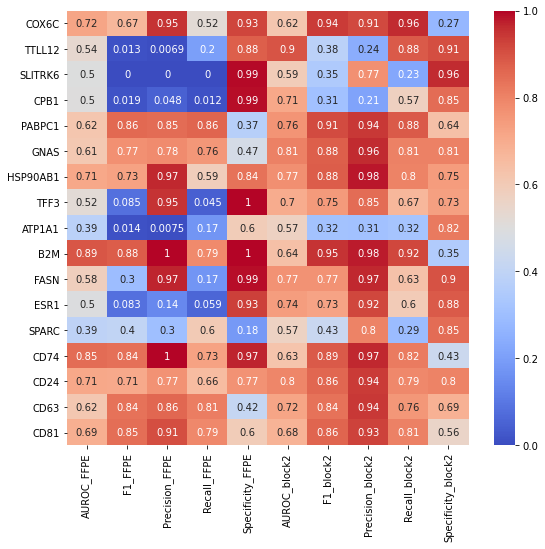

In [12]:
plt.figure(figsize=(9,8))
im = sns.heatmap(roc, cmap="coolwarm", annot= True)
#plt.imsave('D:/Onkar_D/UQ/Project_Spt.Transcriptomics/Output_files/heatmap_ffpe_1160920f.png', im)

In [13]:
roc = pd.melt(roc)
#roc['metrics'] = ["AUROC"]*28+["F1"]*28+["Precision"]*28+["Recall"]*28+["Specificity"]*28
roc['metrics'] = ["AUROC", "AUROC", "F1", "F1", "Precision", "Precision", "Recall", "Recall", "Specificity", "Specificity"]*17
roc['variable'] = roc['variable'].str.split('_', expand=True)[1]

(-0.1, 1.1)

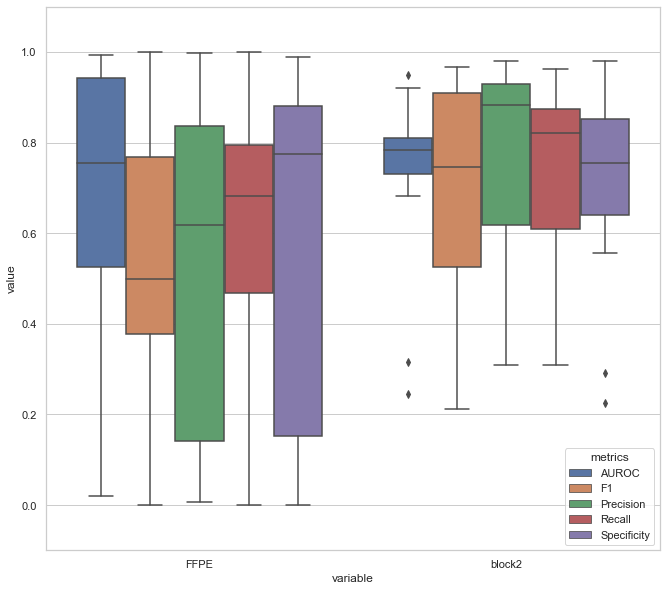

In [14]:
plt.figure(figsize=(11,10))
sns.set_theme(style="whitegrid")
sns.boxplot(x="variable", y="value", hue="metrics", data=roc)
#sns.swarmplot(x="variable", y="value", hue="metrics", data=roc, color=".25")
plt.ylim(-0.1, 1.1)

## Tumor vs Immune rich spots block-2

In [44]:
pred_genes_avg_block2 = copy.copy(pd.DataFrame(pred_block2, index = X_test_block2.index, columns = gene_exp.columns[:-1]))
pred_genes_avg_block2['biomarker_immune_avg'] = pred_genes_avg_block2.iloc[:,[0,6,9]].mean(axis=1) - pred_genes_avg_block2.iloc[:,13:17].mean(axis=1)
pred_genes_avg_block2.head(5)

,COX6C,TTLL12,SLITRK6,CPB1,PABPC1,GNAS,HSP90AB1,TFF3,ATP1A1,B2M,FASN,ESR1,SPARC,CD74,CD24,CD63,CD81,biomarker_immune_avg
tile_tissue_mask_path,,,,,,,,,,,,,,,,,,
block2-6080-3722-299,1,0,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,0.000000
block2-17782-15632-299,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0.500000
block2-9763-4445-299,1,0,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,0.000000
block2-6447-17734-299,1,1,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,0.000000
block2-16716-7079-299,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.333333


## Green spots are high tumor spots and blue are high immune spots

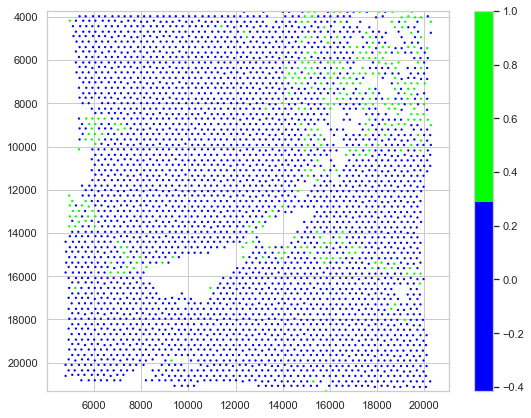

In [48]:
plt.figure(figsize=(9,7))

coordinates_block2 = h5ad.loc[(h5ad['library_id'] == "block2")]
x = coordinates_block2["imagerow"] 
y = coordinates_block2["imagecol"] 
c = pred_genes_avg_block2['biomarker_immune_avg']         
fig1 = plt.gcf()
plt.hexbin(y,x, C=c, cmap = plt.cm.get_cmap('brg', 2), gridsize=300)
plt.ylim(max(x), min(x)) 
plt.colorbar()
plt.show() 

## Tumor vs Immune rich spots FFPE

## LIME

In [15]:
import cv2
gene_list_2 = gene_exp.columns[:-1].to_list()

resnet_model1 = ResNet50(weights="imagenet", include_top=False, input_shape=(299, 299, 3), pooling="avg")


def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image_fun.load_img(img_path, target_size=(299, 299))
        x = image_fun.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        out.append(x)
    return np.vstack(out)

def model_predict_gene(gene):
    i = gene_list_2.index(gene)
    def combine_model_predict(tile1):
        feature1 = resnet_model1.predict(tile1)
        prediction = clf.predict_proba(feature1)#[0]
        return prediction[i]#.reshape(-1,1)
    return combine_model_predict

def model_predict_gene_2(gene):
    i = gene_list_2.index(gene)
    def combine_model_predict(tile1):
        feature1 = resnet_model1.predict(tile1)
        prediction = clf_2.predict_proba(feature1)#[0]
        return prediction[i]#.reshape(-1,1)
    return combine_model_predict

def model_predict_gene_3(gene):
    i = gene_list_2.index(gene)
    def combine_model_predict(tile1):
        feature1 = resnet_model1.predict(tile1)
        prediction = clf_3.predict_proba(feature1)#[0]
        return prediction[i]#.reshape(-1,1)
    return combine_model_predict

def watershed_segment2(image):
    annotation_hed = rgb2hed(image1[0])
    annotation_h = annotation_hed[:,:,0]
    #annotation_h *= 255.0 / np.percentile(annotation_h, q=64)
    thresh = skimage.filters.threshold_otsu(annotation_h)
    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        annotation_h < thresh
    )
    distance = ndi.distance_transform_edt(im_fgnd_mask)
    coords = peak_local_max(distance, footprint=np.ones((5, 5)), labels=im_fgnd_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(annotation_h, markers, mask=im_fgnd_mask)
    im_nuclei_seg_mask = area_opening(labels, area_threshold=0.000001).astype(np.int)
    map_dic = dict(zip(np.unique(im_nuclei_seg_mask), np.arange(len(np.unique(im_nuclei_seg_mask)))))
    im_nuclei_seg_mask = np.vectorize(map_dic.get)(im_nuclei_seg_mask)
    return im_nuclei_seg_mask

def watershed_segment(image):
    annotation_hed = rgb2hed(image)
    annotation_h = annotation_hed[:,:,0]
    annotation_h *= 255.0 / np.percentile(annotation_h, q=80)
    thresh = skimage.filters.threshold_otsu(annotation_h)
    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        annotation_h < thresh
    )
    distance = ndi.distance_transform_edt(im_fgnd_mask)
    coords = peak_local_max(distance, footprint=np.ones((5, 5)), labels=im_fgnd_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(annotation_h, markers, mask=im_fgnd_mask)
    im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int)
    map_dic = dict(zip(np.unique(im_nuclei_seg_mask), np.arange(len(np.unique(im_nuclei_seg_mask)))))
    im_nuclei_seg_mask = np.vectorize(map_dic.get)(im_nuclei_seg_mask)
    return im_nuclei_seg_mask

## COX6C

In [16]:
image1 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\Good_Norm Tiles\\block2\\block2-6750-7761-299.jpeg')])
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image1[0].astype('double'), model_predict_gene("COX6C"), top_labels=2, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)

  0%|          | 0/100 [00:00<?, ?it/s]

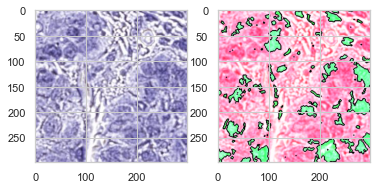

In [17]:
temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
plt.subplot(1,2,1)
plt.imshow(Image.open('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\Good_Norm Tiles\\block2\\block2-6750-7761-299.jpeg'))#block2-5091-14880-299
plt.subplot(1,2,2)
plt.imshow(mark_boundaries(temp, mask).astype('uint8'))

In [18]:
image2 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\Good_Norm Tiles\\block2\\block2-5759-19395-299.jpeg')])
explanation = explainer.explain_instance(image2[0].astype('double'), model_predict_gene("COX6C"), top_labels=2, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)

  0%|          | 0/100 [00:00<?, ?it/s]

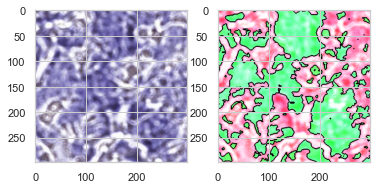

In [19]:
temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
plt.subplot(1,2,1)
plt.imshow(Image.open('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\Good_Norm Tiles\\block2\\block2-5759-19395-299.jpeg'))
plt.subplot(1,2,2)
plt.imshow(mark_boundaries(temp, mask).astype('uint8'))

## CD74

In [20]:
image1 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\Good_Norm Tiles\\block2\\block2-6750-7761-299.jpeg')])
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image1[0].astype('double'), model_predict_gene("CD74"), top_labels=2, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)

  0%|          | 0/100 [00:00<?, ?it/s]

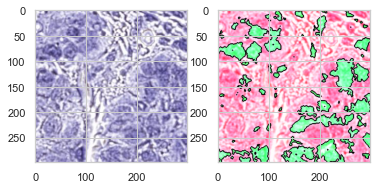

In [21]:
temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
plt.subplot(1,2,1)
plt.imshow(Image.open('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\Good_Norm Tiles\\block2\\block2-6750-7761-299.jpeg'))#block2-5091-14880-299
plt.subplot(1,2,2)
plt.imshow(mark_boundaries(temp, mask).astype('uint8'))

In [22]:
image2 = transform_img_fn([os.path.join('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\Good_Norm Tiles\\block2\\block2-5759-19395-299.jpeg')])
explanation = explainer.explain_instance(image2[0].astype('double'), model_predict_gene("CD74"), top_labels=2, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)

  0%|          | 0/100 [00:00<?, ?it/s]

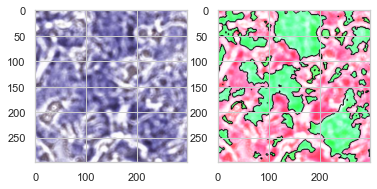

In [23]:
temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
plt.subplot(1,2,1)
plt.imshow(Image.open('D:\\Onkar_D\\UQ\\Project_Spt.Transcriptomics\\Output_files\\Good_Norm Tiles\\block2\\block2-5759-19395-299.jpeg'))
plt.subplot(1,2,2)
plt.imshow(mark_boundaries(temp, mask).astype('uint8'))

## 10X Block2

In [ ]:
dendrogram = sch.dendrogram(sch.linkage(pd.concat([X_test_block2.iloc[:,:-1],pd.DataFrame(pred_block2, index=X_test_block2.index)],axis=1), method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Spots')
plt.ylabel('Euclidean distances')
plt.show()

In [24]:
hc1 = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
Spots1_hc = hc1.fit_predict(pd.concat([X_test_block2.iloc[:,:-1],pd.DataFrame(pred_block2, index=X_test_block2.index)],axis=1))

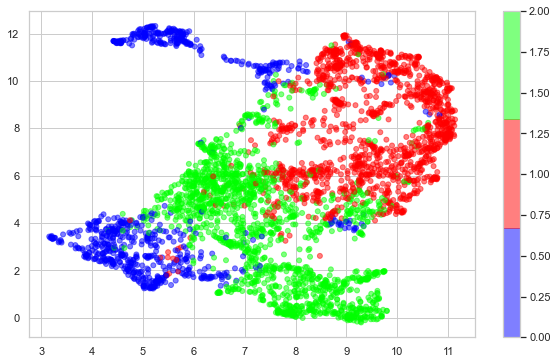

In [25]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(pd.concat([X_test_block2.iloc[:,:-1],pd.DataFrame(pred_block2, index=X_test_block2.index)],axis=1))
fig, ax = plt.subplots(figsize=(10,6))
colormap = plt.scatter(standard_embedding[:, 0].reshape(3770,1), standard_embedding[:, 1].reshape(3770,1), c = Spots1_hc, 
                       s = 25.0, cmap = plt.cm.get_cmap('brg', 3), alpha=0.5)
plt.colorbar();

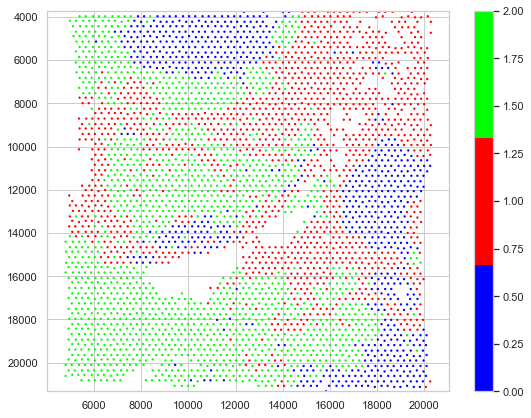

In [26]:
plt.figure(figsize=(9,7))

coordinates_block2 = h5ad.loc[(h5ad['library_id'] == "block2")]
x = coordinates_block2["imagerow"] 
y = coordinates_block2["imagecol"] 
c = Spots1_hc         
fig1 = plt.gcf()
plt.hexbin(y,x, C=c, cmap = plt.cm.get_cmap('brg', 3), gridsize=300)
plt.ylim(max(x), min(x)) 
plt.colorbar()
plt.show() 

## FFPE

In [ ]:
dendrogram = sch.dendrogram(sch.linkage(pd.concat([X_test_FFPE.iloc[:,:-1],pd.DataFrame(pred_FFPE, index=X_test_FFPE.index)],axis=1), method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Spots')
plt.ylabel('Euclidean distances')
plt.show()

In [27]:
hc2 = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
Spots2_hc = hc2.fit_predict(pd.concat([X_test_FFPE.iloc[:,:-1],pd.DataFrame(pred_FFPE, index=X_test_FFPE.index)],axis=1))

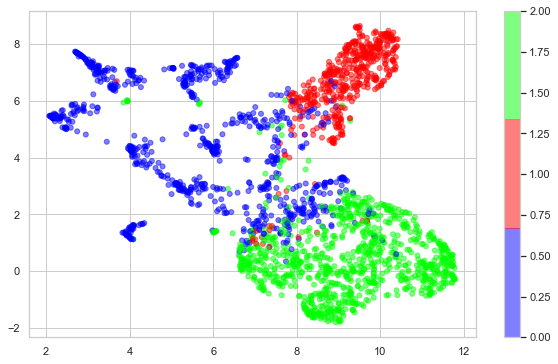

In [28]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(pd.concat([X_test_FFPE.iloc[:,:-1],pd.DataFrame(pred_FFPE, index=X_test_FFPE.index)],axis=1))
fig, ax = plt.subplots(figsize=(10,6))
colormap = plt.scatter(standard_embedding[:, 0].reshape(2338,1), standard_embedding[:, 1].reshape(2338,1), c = Spots2_hc, 
                       s = 25.0, cmap = plt.cm.get_cmap('brg', 3), alpha=0.5)
plt.colorbar();

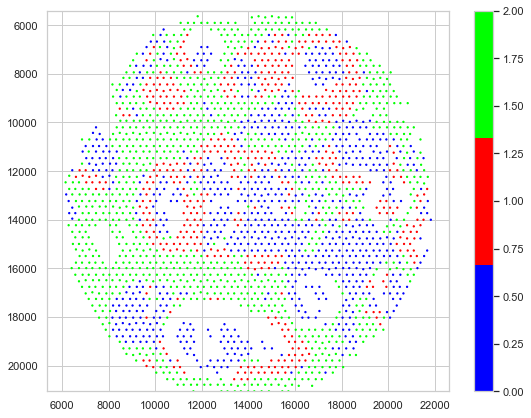

In [29]:
plt.figure(figsize=(9,7))

coordinates_FFPE = h5ad.loc[(h5ad['library_id'] == "FFPE")]
x = coordinates_FFPE["imagerow"] 
y = coordinates_FFPE["imagecol"] 
c = Spots2_hc         
fig1 = plt.gcf()
plt.hexbin(y,x, C=c, cmap = plt.cm.get_cmap('brg', 3), gridsize=300)
plt.ylim(max(x), min(x)) 
plt.colorbar()
plt.show() 